In [ ]:
from phi.torch.flow import *

In [ ]:
backend.default_backend().get_default_device()

In [ ]:
math.get_precision()

In [71]:
from phi.torch.flow import *

BOUNDS = Box(x=1, y=1, z=1)
RESOLUTION = 50
DENSITY = CenteredGrid(
    values=0,
    extrapolation=extrapolation.ZERO_GRADIENT,
    bounds=BOUNDS,
    resolution=spatial(x=RESOLUTION, y=RESOLUTION, z=RESOLUTION),
)
VELOCITY = StaggeredGrid(
    values=0,
    extrapolation=extrapolation.ZERO,
    bounds=BOUNDS,
    resolution=spatial(x=RESOLUTION, y=RESOLUTION, z=RESOLUTION),
)
INFLOW = CenteredGrid(
    values=Sphere(center=tensor([0.5, 0.5, 0.5], channel(vector='x,y,z')), radius=0.1),
    extrapolation=extrapolation.ZERO_GRADIENT,
    bounds=BOUNDS,
    resolution=spatial(x=RESOLUTION, y=RESOLUTION, z=RESOLUTION),
)


@jit_compile
def step(v, s, p, dt, inflow_rate, inflow):
    s = advect.mac_cormack(s, v, dt) + inflow_rate * resample(inflow, to=s, soft=True)
    buoyancy = resample(s * (0, 0.1, 0), to=v)
    v = advect.semi_lagrangian(v, v, dt) + buoyancy * dt
    v, p = fluid.make_incompressible(v, (), Solve('CG', 1e-3, x0=p))
    return v, s, p

In [ ]:
step(VELOCITY, DENSITY, None, 0.2, 0.2, INFLOW)

In [ ]:
from phi.torch.flow import *

RESOLUTION = 50
BOUNDS = Box(x=1, y=1, z=1)
tensor = torch.zeros(50, 50, 50, device=torch.device('cuda'))
DENSITY = CenteredGrid(
    values=wrap(tensor, spatial('x,y,z')),
    extrapolation=extrapolation.ZERO_GRADIENT,
    bounds=BOUNDS,
    # resolution=spatial(x=RESOLUTION, y=RESOLUTION, z=RESOLUTION),
)

In [68]:
sin_train = torch.nn.Parameter(torch.zeros(100))
optimizer = torch.optim.Adam([sin_train], lr=0.01)

x = torch.linspace(0, 3, 100)
target = torch.sin(x)

In [69]:
# 开始训练
for epoch in range(1000):  # 训练 1000 次
    optimizer.zero_grad()  # 清空梯度
    loss = torch.nn.functional.mse_loss(sin_train, target)  # 均方误差损失
    loss.backward()  # 计算梯度
    optimizer.step()  # 更新参数

    # 每 100 个 epoch 打印一次损失
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# 打印最终结果
print("Final sin_train:", sin_train.data)
print("Target (sin(x)):", target)

Epoch 0, Loss: 0.5181443095207214
Epoch 100, Loss: 0.014752180315554142
Epoch 200, Loss: 4.392676055431366e-05
Epoch 300, Loss: 3.5782783402993346e-09
Epoch 400, Loss: 8.309366785136732e-14
Epoch 500, Loss: 4.8134829184597744e-14
Epoch 600, Loss: 4.488409630402056e-14
Epoch 700, Loss: 4.2412738767002786e-14
Epoch 800, Loss: 3.818279175368637e-14
Epoch 900, Loss: 3.698374885421213e-14
Final sin_train: tensor([0.0000, 0.0303, 0.0606, 0.0908, 0.1209, 0.1509, 0.1808, 0.2105, 0.2401,
        0.2694, 0.2984, 0.3272, 0.3557, 0.3838, 0.4116, 0.4391, 0.4661, 0.4927,
        0.5188, 0.5445, 0.5696, 0.5943, 0.6184, 0.6419, 0.6648, 0.6872, 0.7089,
        0.7299, 0.7503, 0.7700, 0.7889, 0.8072, 0.8247, 0.8415, 0.8575, 0.8727,
        0.8870, 0.9006, 0.9134, 0.9253, 0.9364, 0.9466, 0.9559, 0.9644, 0.9719,
        0.9786, 0.9844, 0.9893, 0.9933, 0.9963, 0.9985, 0.9997, 1.0000, 0.9994,
        0.9979, 0.9954, 0.9921, 0.9878, 0.9826, 0.9765, 0.9696, 0.9617, 0.9529,
        0.9433, 0.9328, 0.9215, 0.90

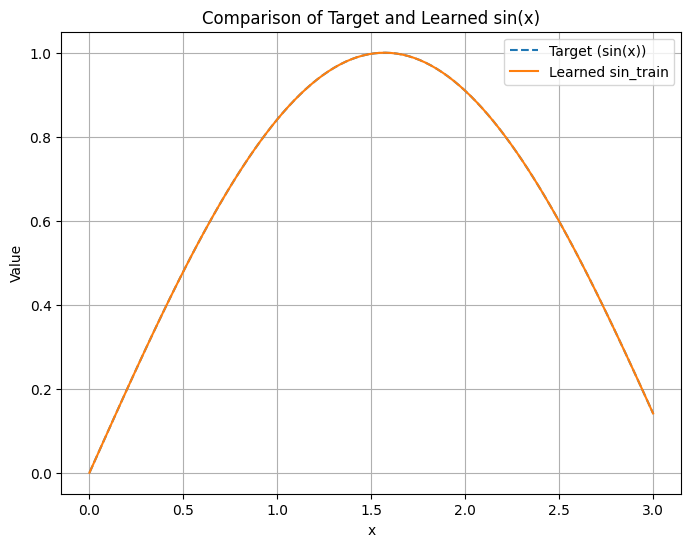

In [70]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(x.detach().numpy(), target.detach().numpy(), label="Target (sin(x))", linestyle="dashed")
plt.plot(x.detach().numpy(), sin_train.detach().numpy(), label="Learned sin_train", linestyle="solid")
plt.legend()
plt.xlabel("x")
plt.ylabel("Value")
plt.title("Comparison of Target and Learned sin(x)")
plt.grid(True)
plt.show()